# Exploration of AI data for the RWJF project

Here we explore the AI data for the RWJF project. This involves:

* Analysing World Report
  * Load
  * Map
  * Trend analysis
  * MeSH exploration
  
* Consider other sources such as CrunchBase or GitHub to illustrate the range of sources we are working with.




In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import ast

## World Reporter

First import of the data - I chunked this because it was killing my Python

In [218]:
# my_files = os.listdir('../data/external/for_juan/')

# dfs_list = []

# dfs_in_5s = []

# counter = 0

# for file in my_files:
    
#     counter+=1
#     #Problem file!
#     if any(x in file for x in ['590000','180000','1170000','490000']):
#         continue
#     df = pd.read_json(f'../data/external/for_juan/{file}')
#     dfs_list.append(df)
    
#     if counter % 10==0:
#         print(counter)
#         dfs_in_5s.append(pd.concat(dfs_list))
#         dfs_list=[]

# wr = pd.concat(dfs_in_5s+dfs_list)
#wr.to_csv(f'../data/external/{today_str}wr_data.csv',compression='gzip')

In [5]:
wr = pd.read_csv('../data/external/8_11_2018wr_data.csv',error_bad_lines=False,compression='gzip',
                 converters={'terms_mesh_abstract':ast.literal_eval})

In [3]:
wr.shape

(1520000, 23)

In [7]:
wr.reset_index(drop=True,inplace=True)

In [8]:
# Below we find that the IDs don't seem to relate to unique projects so I create my own here

wr['my_id'] = ['id_'+str(n) for n in range(len(wr))]

wr.set_index('my_id',inplace=True)

### Initial exploration of world reporter

Protocol:

* What is in it?
  * Missing values
  * Types of entities
  * Entities relevant for the project (in this case health innovations)
  
* When does it cover?
  * How many years

* Where are these organisations?
  * Geography.

#### What is in it

In [9]:
#wr.apply(lambda x: x.isna().mean()).sort_values().plot.barh(color='navy')

Things to do:

* Why are there duplicates?
* What is the difference between project description and project abstract?


In [10]:
#On the duplicate abstracts

wr.booleanFlag_duplicate_abstract.sum()

219702.0

In [11]:
abstract_short = wr['textBody_abstract_project'].apply(lambda x: x[:1000] if type(x)==str else np.nan)

abstract_short.value_counts()[:5]

ABSTRACT NOT PROVIDED                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      2149
No Abstract Provided                                                                                                                                                                                                                                                                                                                                                                                                    

A few missing values

In [12]:
print(sum(abstract_short.value_counts()>1))

print(sum(abstract_short.value_counts()==1))

371826
175807


There are 371827 beginnings of abstracts that appear more than once, and 157807 abstracts that appear *just once*. This means there are ~500K unique abstract texts. 

We will need to do some serious deduplication here.

Are any of the repeats because eg multiple organisations received a grant?

In [13]:
abstract_short.value_counts()[:10]

ABSTRACT NOT PROVIDED                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              2149
No Abstract Provided                                                                                                            

Some of the duplicates are repeating grants and awards involving multiple institutions. Let's check the one right above: 

Let's find abstracts missing

In [14]:
missing_abs = [any(x in text.lower() for x in ['abstract','no','not']) & (len(text)<100) for 
               text in wr['textBody_abstract_project'].dropna()]

In [15]:
sum(missing_abs)

8294

Not a crazy number of missing abstracts beyond the NAs

#### Check one project where there are repeated abstracts

In [16]:
text_of_interest = "This contract is for a clinical center which is one of an estimated twenty-five centers that will conduct a large scale clinical trial on left ventricular dysfunction."

In [17]:
projects_with_text = wr.loc[[text_of_interest in text for text in wr.textBody_abstract_project.dropna()]]


In [18]:
projects_with_text.head(n=20)[['title_of_organisation','terms_mesh_abstract']]

,title_of_organisation,terms_mesh_abstract
my_id,,
id_269711,BAYLOR COLLEGE OF MEDICINE,"[Humans, Female, Cysteine, Lanthanoid Series E..."
id_270112,UNIVERSITY OF PENNSYLVANIA,"[Adult, Humans, Animals, Mice, Capillaries, Pa..."
id_270121,NaN,"[Animals, Cattle, Protein Conformation, beta-S..."
id_270130,NaN,"[Mice, Animals, Humans, Autoantibodies, Immuno..."
id_270139,UNIVERSITY OF IDAHO,"[Humans, Public Health, Pandemics, Mentors, In..."
id_270148,LSU PENNINGTON BIOMEDICAL RESEARCH CTR,"[Male, Child, United States, Humans, Prevalenc..."
id_270157,UNIVERSITY OF CALIFORNIA LOS ANGELES,"[Humans, Mice, Animals, Proteasome Endopeptida..."
id_270166,JOHNS HOPKINS UNIVERSITY,"[Humans, Translational Medical Research, Compu..."
id_270175,NORTH CAROLINA STATE UNIVERSITY RALEIGH,"[Humans, Animals, Mice, Precision Medicine, Go..."


So this gives different organisations with the same MeSH terms. We should use the set of 'unique abstracts' for any querying 

#### Differences between text abstracts and paper abstracts

In [19]:
import random

for x in random.sample(range(len(wr)),5):
    
    print(wr.iloc[x]['textBody_descriptive_project'])
    
    print('\n')
    
    print(wr.iloc[x]['textBody_abstract_project'])
    
    print('\n')
    print('===')

nan


After infection of E. coli by bacteriophage T4, the host RNA polymerase acquires several small phage-induced polypeptides and its alfa subunits are ADP-ribosylated. The role of these modifications in transcription control will be studied using a combination of biochemical, genetic and physiological approaches. We have purified four of the associated polypeptides (15K, 19K, 25K and 29K proteins) as well as RNA polymerases differing in the state of ADP-ribosylation and propose to study their interactions in direct binding assays. The kinetics of in vivo formation of these proteins and their interactions with other intracellular components will be analysed in order to understand the coordination between transcription and other events of T4 development such as DNA replication. We will identify T4 genes involved in the modifications and use their mutants to determine their role in phage development. In vitro experiments are proposed to study the interaction of normal and modified RNA 

The descriptions are an executive summary and the abstract is the scientific abstract

#### How many IDs do we have?

In [20]:
len(set(wr['id_of_project']))


1106542

In [21]:
pd.crosstab(wr['id_of_project'].duplicated(),wr['booleanFlag_duplicate_abstract'].isna(),normalize=1)

booleanFlag_duplicate_abstract,False,True
id_of_project,,
False,0.707877,0.731386
True,0.292123,0.268614


There isn't a visible correlation between abstract duplicates and id duplicates

In [22]:
wr['id_of_project'].value_counts().head()

3P41RR001209-23S1    564
2P41RR001209-31      470
5P41RR001209-30      396
5M01RR000051-34      381
5M01RR000585-22      364
Name: id_of_project, dtype: int64

In [23]:
wr.loc[wr['id_of_project']=='3P41RR001209-23S1']['title_of_project'].head()

my_id
id_270970    LAUE STUDIES OF RB SPHAEROIDES PHOTOSYNTHETIC ...
id_270979    STAFF PRIORITY TIME CRYO COOLING OF METHANE MO...
id_270988    HI RES ANOMALOUS DATA FROM PLATINUM SOAKED CRY...
id_270997    MAD DIFFRACTION DATA COLLECTION FROM CYTOCHROM...
id_271006         TRITRICHOMONAS FOETUS PURINE SALVAGE ENZYMES
Name: title_of_project, dtype: object

I don't think that project id means what I think it does - the above are somewhat different although all seem to relate to chrystalography.

#### Organisations receiving grants

In [24]:
print(len(set(wr.title_of_organisation)))

wr.title_of_organisation.value_counts().head(n=10)

9480


JOHNS HOPKINS UNIVERSITY                  20654
UNIVERSITY OF PENNSYLVANIA                18350
UNIVERSITY OF WASHINGTON                  16955
UNIVERSITY OF PITTSBURGH AT PITTSBURGH    15127
UNIVERSITY OF CALIFORNIA LOS ANGELES      14796
WASHINGTON UNIVERSITY                     13677
YALE UNIVERSITY                           13658
STANFORD UNIVERSITY                       13558
UNIVERSITY OF CALIFORNIA SAN DIEGO        12705
DUKE UNIVERSITY                           12318
Name: title_of_organisation, dtype: int64

The organisations are mostly universities although we also find some companies

#### Relevant entities: do we find social/digital innovations?

To get a handle on this I will explore the MeSH terms. What are the top terms? Can we cluster them and if so do we find a digital/social cluster?


In [25]:
def flatten(a_list):
    '''
    flattens a list
    '''
    
    out = [x for el in a_list for x in el]
    
    return(out)


def term_distr(a_list):
    '''
    Counts elements in a flat list
    
    '''
    
    return(pd.Series(flatten(a_list)).value_counts())
    
    

In [26]:
mesh_distr = term_distr(wr.terms_mesh_abstract)

In [27]:
mesh_distr.head(n=10)

Humans           889279
Animals          638488
Goals            459083
Mice             278280
Female           189669
United States    144499
Male             122818
Rats             116165
Child            112867
DNA              108553
dtype: int64

In [28]:
len(mesh_distr)

53623

There are 53,263 MeSH terms

(array([5.3609e+04, 9.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e+00, 8.892880e+04, 1.778566e+05, 2.667844e+05,
        3.557122e+05, 4.446400e+05, 5.335678e+05, 6.224956e+05,
        7.114234e+05, 8.003512e+05, 8.892790e+05]),
 <a list of 10 Patch objects>)

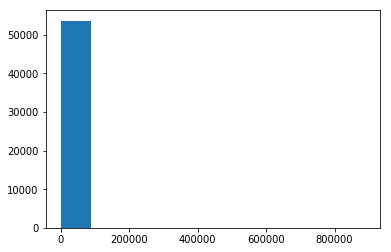

In [217]:
plt.hist(mesh_distr)

Most MeSH terms appear once.

#### How do we cluster them?

Options:


* Topic modelling
* community detection on topic co-occurrence network
* semantic clustering on w2v model


All these options might take a while. For now I'm going to take it very easy and simply look for digital and social terms and their synonyms

In [30]:
#Lowercase
tokenised = [[x.lower() for x in tokens] for tokens in wr.terms_mesh_abstract]

In [31]:
wr['mesh_lower'] = tokenised

In [32]:
tokenised[0]

['aged',
 'mice',
 'animals',
 'humans',
 'herpesvirus 4, human',
 'infectious mononucleosis',
 'hla-a2 antigen',
 'influenza, human',
 'vaccinia virus',
 'hepacivirus',
 'immunity, heterologous',
 'muromegalovirus',
 'viral load',
 'epitopes',
 'arenavirus',
 't-lymphocytes',
 'epstein-barr virus infections',
 'somatoform disorders',
 'influenza vaccines',
 'social problems',
 'dengue',
 'religious philosophies',
 'models, animal',
 'cd8-positive t-lymphocytes']

In [33]:
from gensim.models import Word2Vec

w2v = Word2Vec(tokenised)

In [34]:
def expanded_query(w2v,term,steps,thres=0.6,counts=True):
    '''
    Runs an expanded query on a w2v model. Steps is the number of steps it takes beyond the initial expansion.
    counts is whether it returns a count of term appearances, or a set.
    
    '''
    
    #Seed
    seed = [x[0] for x in w2v.wv.most_similar(term) if x[1]>thres]
    
    #return(seed)

    counter =0
        
    while counter<=steps:
        
        expand = [w2v.wv.most_similar(x) for x in set(seed)]
        
        new_set = list(set([x[0] for x in flatten(expand) if x[1]>thres]))
        
        seed = seed+new_set
        
        counter+=1
        
    #return(term_distr(seed))
    if counts==True:
        return(pd.Series(seed).value_counts())
    
    else:
        return(set(seed))

In [35]:
software_synonyms =expanded_query(w2v,'software',steps=2) 

software_synonyms.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


microcomputers                       4
information storage and retrieval    4
algorithms                           4
computer communication networks      4
automation                           4
vocabulary, controlled               4
computing methodologies              4
computer systems                     4
internet                             4
data mining                          4
dtype: int64

In [36]:
online_synonyms = expanded_query(w2v,'internet',steps=2) 

online_synonyms.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


books                                4
documentation                        4
telecommunications                   4
simulation training                  4
referral and consultation            4
computers, handheld                  4
information services                 4
marketing                            4
information storage and retrieval    4
information management               4
dtype: int64

In [37]:
social_env = expanded_query(w2v,'social environment',steps=2) 

social_env.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


personality                4
social support             4
self concept               4
peer group                 4
anger                      4
social class               4
interpersonal relations    4
domestic violence          4
marital status             4
violence                   4
dtype: int64

In [38]:
peer = expanded_query(w2v,'health behavior',steps=2) 

peer.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


exercise                   4
life style                 4
social class               4
attitude                   4
social support             4
primary prevention         4
health education           4
health promotion           4
risk reduction behavior    4
health status              4
dtype: int64

In [39]:
health_pol = expanded_query(w2v,'health policy',steps=2) 

health_pol.head(n=10)

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


quality of health care           4
health services accessibility    4
economics, medical               4
evidence-based practice          4
health personnel                 4
policy making                    4
insurance coverage               4
public health practice           4
public policy                    4
evidence-based medicine          3
dtype: int64

Lots of relevant keywords...but how many projects?

In [40]:
def extract_projects(df,term_list,appearances,label):
    '''
    Returns projects if relevant terms appear in it. Relevance is based on the number of times a term
    appeared in the expanded kw search
    
    '''
    
    terms = term_list.index[term_list>appearances]
    
    print(terms)
    
    projs = df.loc[[any(x in mesh for x in terms) for mesh in df.mesh_lower]]
    
    projs[f'has_{label}'] =True 
    
    print(len(projs))
    
    return(projs)

In [41]:
digital_projects = extract_projects(wr,
                                    pd.concat([online_synonyms,software_synonyms]),
                                    3,'digital')

Index(['books', 'documentation', 'telecommunications', 'simulation training',
       'referral and consultation', 'computers, handheld',
       'information services', 'marketing',
       'information storage and retrieval', 'information management',
       'microcomputers', 'information storage and retrieval', 'algorithms',
       'computer communication networks', 'automation',
       'vocabulary, controlled', 'computing methodologies', 'computer systems',
       'internet', 'data mining'],
      dtype='object')
72108


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
social_projects = extract_projects(wr,
                                   pd.concat([social_env,peer]),
                                    3,'social')

Index(['personality', 'social support', 'self concept', 'peer group', 'anger',
       'social class', 'interpersonal relations', 'domestic violence',
       'marital status', 'violence', 'exercise', 'life style', 'social class',
       'attitude', 'social support', 'primary prevention', 'health education',
       'health promotion', 'risk reduction behavior', 'health status'],
      dtype='object')
71935


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
policy_projects = extract_projects(wr,
                                  health_pol,3,'policy')

Index(['quality of health care', 'health services accessibility',
       'economics, medical', 'evidence-based practice', 'health personnel',
       'policy making', 'insurance coverage', 'public health practice',
       'public policy'],
      dtype='object')
16375


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Non-insignificant numbers. There will be duplicates though!

In [44]:
def sample_projects(df,variable,sample_size,length_text):
    '''
    Sample some projects
    '''
    
    rel= random.sample(list(df[variable]),sample_size)
    
    for item in rel:
        
        print(item[:length_text])
        print('\n')
    

In [45]:
sample_projects(digital_projects,'textBody_abstract_project',5,500)

Malignant mesothelioma is a disease of growing importance. Its incidence is increasing as a result of the widespread use of its major etiologic agent, asbestos exposure, which is implicated in 70 to 80% of patients. The ubiquitous presence of asbestos, from schools to shipyards, has generated great public concern and awareness of this disease. Malignant mesothelioma is uniformly fatal, and neither surgery nor radiotherapy is curative. Very little information is available regarding the activity o


 [unreadable] DESCRIPTION (provided by applicant): [unreadable] Background and Significance. Diabetes is a growing, debilitating chronic disease that contributes to morbidity and mortality. Few studies have examined diabetes and comorbid conditions and their relationships to mortality over 9 years among adults aged 18 and over. [unreadable] Aims. For the population of adult enrollees with diabetes mellitus continuously enrolled in Group Health between 1997-2006, aims are to: 1) estimate the p

In [46]:
sample_projects(social_projects,'textBody_abstract_project',5,500)

This study which, is being submitted in response to PA-99-134 a request for Exploratory/Developmental Grants (R21) for Mental Health Intervention Research, will be conducted at the New York Presbyterian Hospital Regional Burn Center which offers a large heterogeneous population representing both minorities (40 percent) and women (25 percent), where 41 percent of injuries are work-related, and where an alliance between the surgical staff and proposed research team have been well established. Thou


 DESCRIPTION (provided by applicant): Uncovering &confirming gene-environment interactions in stress-related psychopathology. The proposed research will to bring together 3 longitudinal cohort studies (comprising 4 cohort samples) in order to create a powerful epidemiological resource for testing hypotheses about gene- environment interaction (GxE), and for replicating these findings. Using this multi-study resource, we seek to identify genetic pathways of stress resistance by studying sets o

In [47]:
sample_projects(policy_projects,'textBody_abstract_project',5,500)

 [unreadable] DESCRIPTION (provided by applicant): South Africa currently has more HIV infected citizens than any other country in the world. Identification of HIV-infected individuals and rapid detection of tuberculosis co-infection is paramount for improving access to treatment, decreasing morbidity, and controlling the spread of the epidemic. Despite promotion of free voluntary counseling and testing (VCT) sites by the government and the near universal offer of antiretroviral therapy, only 1 


 DESCRIPTION (provided by applicant): In the report Five Years After to Err is Human, it was noted that "the combination of complexity, professional fragmentation, and a tradition of individualism, enhanced by a well-entrenched hierarchical authority structure and diffuse accountability, forms a daunting barrier to creating the habits and beliefs of common purpose, teamwork, and individual accountability for successful interdependence that a safe culture requires." Training physicians, nurses

### Check more interesting projects

Do they overlap?

Who is doing them?

In [48]:
#This concatenates the dfs we extracted above.
interest_df = pd.concat([digital_projects,social_projects,policy_projects],
                        axis=1,sort=False)

In [49]:
for x in ['has_digital','has_social','has_policy']:
    interest_df[x] = interest_df[x].fillna(False)

In [50]:
pd.crosstab(interest_df['has_digital'],interest_df['has_policy'],normalize=1)

pd.crosstab(interest_df['has_social'],interest_df['has_policy'],normalize=0)

pd.crosstab(interest_df['has_digital'],interest_df['has_policy'],normalize=0)

has_policy,False,True
has_digital,,
False,0.819067,0.180933
True,0.961780,0.038220


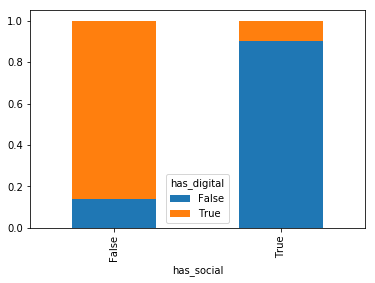

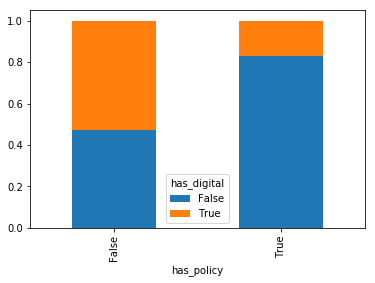

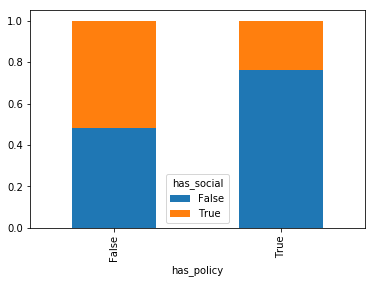

In [51]:
from itertools import combinations

combs = list(combinations(['has_digital','has_social','has_policy'],2))

for comb in combs:
    
    ct = pd.crosstab(interest_df[comb[0]],interest_df[comb[1]],normalize=1)
    ct.T.plot.bar(stacked=True)

In [52]:
top_200_institutions = wr.title_of_organisation.value_counts()[:200]

### Check time coverage

#### Timeseries




In [53]:
def get_time_series(df,var):
    '''
    Produces a time-series of the data after splitting by year
    
    '''
    
    ts = df[var].dropna().apply(lambda x: int(x.split('-')[0])).value_counts()
    ts =ts[sorted(ts.index)]
    
    return(ts)

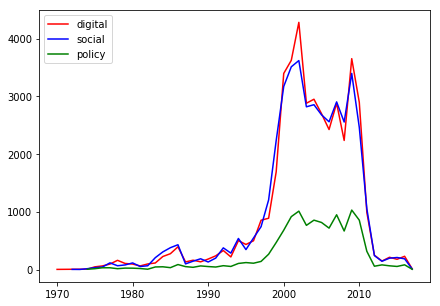

In [54]:
fig, ax =plt.subplots(figsize=(7,5))

#get_time_series(wr,'date_start_project').plot(ax=ax)
get_time_series(digital_projects,'date_start_project').plot(ax=ax,color='red')
get_time_series(social_projects,'date_start_project').plot(ax=ax,color='blue')
get_time_series(policy_projects,'date_start_project').plot(ax=ax,color='green')

ax.legend(labels=['digital','social','policy'],loc='upper left')

The coverage seems relevant for the 2000s. Recent coverage (post 2000) doesn't look brilliant

### Check spatial coverage

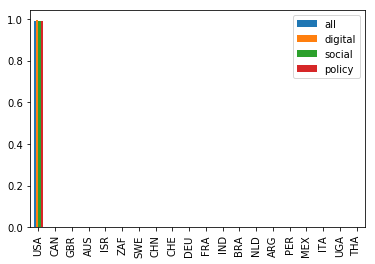

In [55]:
country_cov= pd.concat(
    [df['id_iso3_country'].value_counts(normalize=True) 
     for df in [wr,digital_projects,social_projects,policy_projects]],axis=1,sort=True)

country_cov.columns= ['all','digital','social','policy']

top_20_countries = wr.id_iso3_country.value_counts()[:20].index 
country_cov.loc[top_20_countries].plot.bar()

In terms of funded organisations, the coverage is quite stark

### And regions?

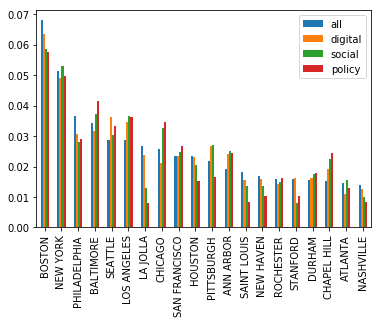

In [56]:
country_cov= pd.concat(
    [df['placeName_city_organisation'].value_counts(normalize=True) 
     for df in [wr,digital_projects,social_projects,policy_projects]],axis=1,sort=True)

country_cov.columns= ['all','digital','social','policy']

top_20_countries = wr.placeName_city_organisation.value_counts()[:20].index 
country_cov.loc[top_20_countries].plot.bar()

## AI analysis on the WR data and other sources

In [57]:
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np

#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def bigram(self,threshold=10):
        '''
        Optional Create bigrams.
        
        '''
        
        #Colocation detector trained on the data
        phrases = models.Phrases(self.tokenised,threshold=threshold)
        
        bigram = models.phrases.Phraser(phrases)
        
        self.tokenised = bigram[self.tokenised]
        
        return(self)
        
        
        
        

class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def _filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
    
    def clean(self):
        '''
        Remove symbols and numbers
        
        '''
        
        
        
    
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


### Load the labelled dataset from George

In [58]:
gdb = pd.read_csv('../data/external/gdb.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,5,7,10,11,12,13,14,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
gdb.shape

(146691, 23)

In [60]:
gdb['source_detailed'] = [x if x!='GDB' else y for x,y in zip(gdb.source_id,
                                                                    gdb.gdb_dataset_id)]

But no MESH terms?

In [61]:
#Drop the gdbs with no descriptions (we can't use them)

gdb.dropna(axis=0,subset=['description'],inplace=True)

Load the AI aids and identify preliminary AI health projects

In [62]:
#Load the AI ids I got from other analysis (this is such a mess!)

ai_ids = pd.read_csv('../data/external/ai_ids.csv',header=None)

In [63]:
#gdb['has_ai'] = gdb.row_id.apply(lambda x: x in ai_ids[1])

gdb.set_index('row_id',inplace=True)

ai_projects = gdb.loc[set(ai_ids[1]) & set(gdb.index)]

Next steps

1. Label variables with their source names
2. Group projects by source names and extract tfidf values
3. Produce wordclouds comparing different types

#### Label variables

In [203]:
ai_projects.source_detailed.value_counts()

rgov              2359
H2020             1026
gtr                714
Crunchbase         262
world_reporter     200
innovateuk         184
ahrq               118
rwjf                29
Name: source_detailed, dtype: int64

In [65]:
#Create aggregated corpora

ai_corpus = ai_projects.groupby(['source_detailed'])['description'].apply(lambda x: ' '.join(list(x)))

#### Extract tfidf descriptions

In [66]:
#This cleans up the corpus
cleaner = CleanTokenize(ai_corpus)

cleaner.clean().bigram()

In [67]:
#This generates TFIDF terms by group in the corpus
salient = LdaPipeline(cleaner.tokenised)

salient._filter(minimum=30).process().tfidf()

In [68]:
processed_corpus = salient.corpus

id_token_lookup = {v:k for k,v in salient.dictionary.token2id.items()}

In [195]:
#This extracts the top 1000 tfidf words in each document

top_words = [[id_token_lookup[val[0]] for val in sorted(x,key=lambda x: x[1],reverse=True)[:1000]] for x in processed_corpus]

In [196]:
#Put them in the corpus

ai_corpus = pd.DataFrame(ai_corpus)

ai_corpus['high_tfidf'] = top_words

ai_corpus['tokenised'] = cleaner.tokenised

#Create list of high tfidf tokens

ai_corpus['tokenised_high_tfidf'] = [[el for el in x if el in y] for x,y in zip(ai_corpus['tokenised'],
                                                                                 ai_corpus['high_tfidf'])]

TODO: Reproduce all this analysis comparing salience of AI / non-AI projects as well as robustness of changes in parameters (ie number of terms we filter during pre-processing, number of TFIDF terms we focus on...)

#### Visualise

Wordcloud! Sorry everyone

In [197]:
from wordcloud import WordCloud

In [200]:
def get_wordcloud(df,source,variable='tokenised_high_tfidf'):
    '''
    Extracts a wordcloud from the data
    
    
    '''
    
    #my_text = df[(df.has_ai==True)&(df.top_discipline==discipline)&([y in years for y in df.start_year])][variable]
    my_text = df[(df.index==source)][variable]
    
    
    my_text_string = ', '.join(list(my_text)[0])
    
    wc = WordCloud()

    out = wc.generate_from_text(my_text_string)
    
    return(out)
    
    
def create_wordcloud(wc_object,source,ax):
    '''
    Creates a wordcloud plot from tw charts
    
    '''
    ax.imshow(wc_object)

    ax.set_axis_off()

    ax.set_title(f'{source}',size=18)
        
    return(ax)

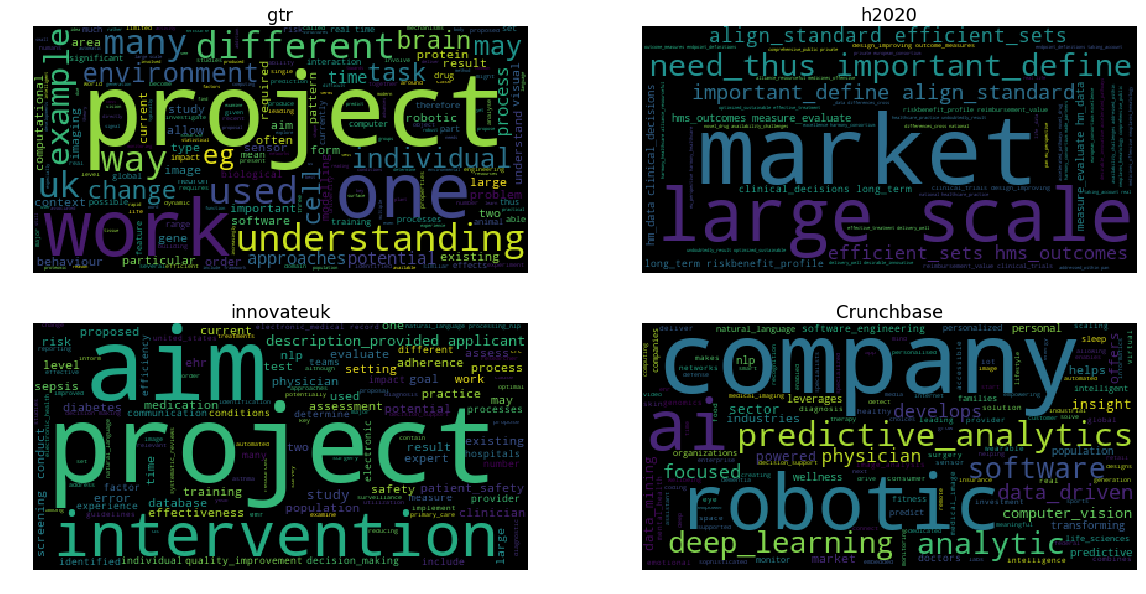

In [201]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(20,10))

create_wordcloud(get_wordcloud(ai_corpus,'gtr'),'gtr',ax=ax[0][0])
create_wordcloud(get_wordcloud(ai_corpus,'H2020'),'h2020',ax=ax[0][1])
create_wordcloud(get_wordcloud(ai_corpus,'ahrq'),'innovateuk',ax=ax[1][0])
create_wordcloud(get_wordcloud(ai_corpus,'Crunchbase'),'Crunchbase',ax=ax[1][1])

plt.savefig(f'../reports/figures/{today_str}_salient_terms_funder.pdf')

#### Examples

This takes 3 random examples from the GDB data

In [205]:
for x in set(ai_projects.source_detailed):
    
    print(x)
    sample_projects(ai_projects.loc[ai_projects.source_detailed==x],'description',3,1000)
    
    print('====')   

innovateuk
Can a better understanding of your personal characteristics help unlock new insights into disease? Could your credit score, your income and your shopping habits help predict whether you are about to have a heart attack? This project focuses on people with diabetes- specifically looking at whether linking big atypical, non-health data sets with health data can reliably predict who is likely to benefit from a health intervention or who is not. Outcomes Based Healthcare, Big Data Partnership, Camden Clinical Commissioning Group and the University of Surrey are working together to research exactly these questions over the next two years. These insights will enable clinicians to understand whether their preventative measures or interventions are likely to be effective, ineffective, wasteful, or even harmful. This moves from a disease-based to a personalised, data-driven health system. To paraphrase Aristotle, it is really important to understand what sort of person has a disease,

### Something on the World Reporter data

In this case, load the mesh lookup and check the top MeSH categories (diseases etc) being mentioned by AI / non AI projects


In [75]:
import ast

#### Load AI data

In [77]:
ai = pd.read_csv('../data/external/world_reporter/ai_projects',converters={'terms_mesh_abstract':ast.literal_eval}
                )

#### Load MeSH

This is a lookup created by George. I use it to split MeSh terms into their groups. There will be some double counting because several MeSH terms appear in multiple categories.

In [78]:
mesh = pd.read_csv('../data/processed/mesh_lookup.csv')

#Here we should create a collection of MeSH terms for each group

mesh_sets = mesh.groupby('tree_string_0')['DescriptorNameString'].apply(lambda x: list(x))


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Work with a sample of world reporter projects because otherwise it takses too long

In [90]:
random.seed(667)
selection = random.sample(range(0,len(wr)),75000)

In [91]:
wr_sample = wr.iloc[selection]

#### We are simply counting the total number of MeSH terms by MeSH category in AI projects and in the WR sample total

In [100]:
comparisons = []

for var in mesh_sets.index:
    print(var)
    print('ai')
    #ai[var] = [[x for x in mesh if x.lower() in mesh_sets[var]] for mesh in ai['terms_mesh_abstract']]
    
    ai_terms = term_distr(ai['terms_mesh_abstract'].apply(lambda x: [t for t in x if t in mesh_sets[var]]))
    
    print('wr')
    wr_terms = term_distr(wr_sample['terms_mesh_abstract'].apply(lambda x: [t for t in x if t in mesh_sets[var]]))
    

    #Concatenate the outputs into a table
    
    comp = pd.concat([ai_terms,wr_terms],axis=1).fillna(0)
    
    comp.columns = [var[:10]+'_ai',var[:10]+'_wr']
    
    comparisons.append(comp)

analytical, diagnostic, and therapeutic techniques, and equipment
ai
wr


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


anatomy
ai
wr
anthropology, education, sociology, and social phenomena
ai
wr
chemicals and drugs
ai
wr
disciplines and occupations
ai
wr
diseases
ai
wr
geographicals
ai
wr
health care
ai
wr
humanities
ai
wr
information science
ai
wr
named groups
ai
wr
organisms
ai
wr
phenomena and processes
ai
wr
psychiatry and psychology
ai
wr
publication characteristics
ai
wr
technology, industry, and agriculture
ai
wr


#### We plot some of the findings

In [215]:
#This list controls what MeSH terms are plotted and how we refer to them (some of the names above are too large for plotting)

to_plot = [[0,'Techniques'],
           #[2,'social_groups'],
           [5,'Diseases'],[7,'Health_care'],[13,'Psychiatry_psychology']]

In the plot, we focus on the 

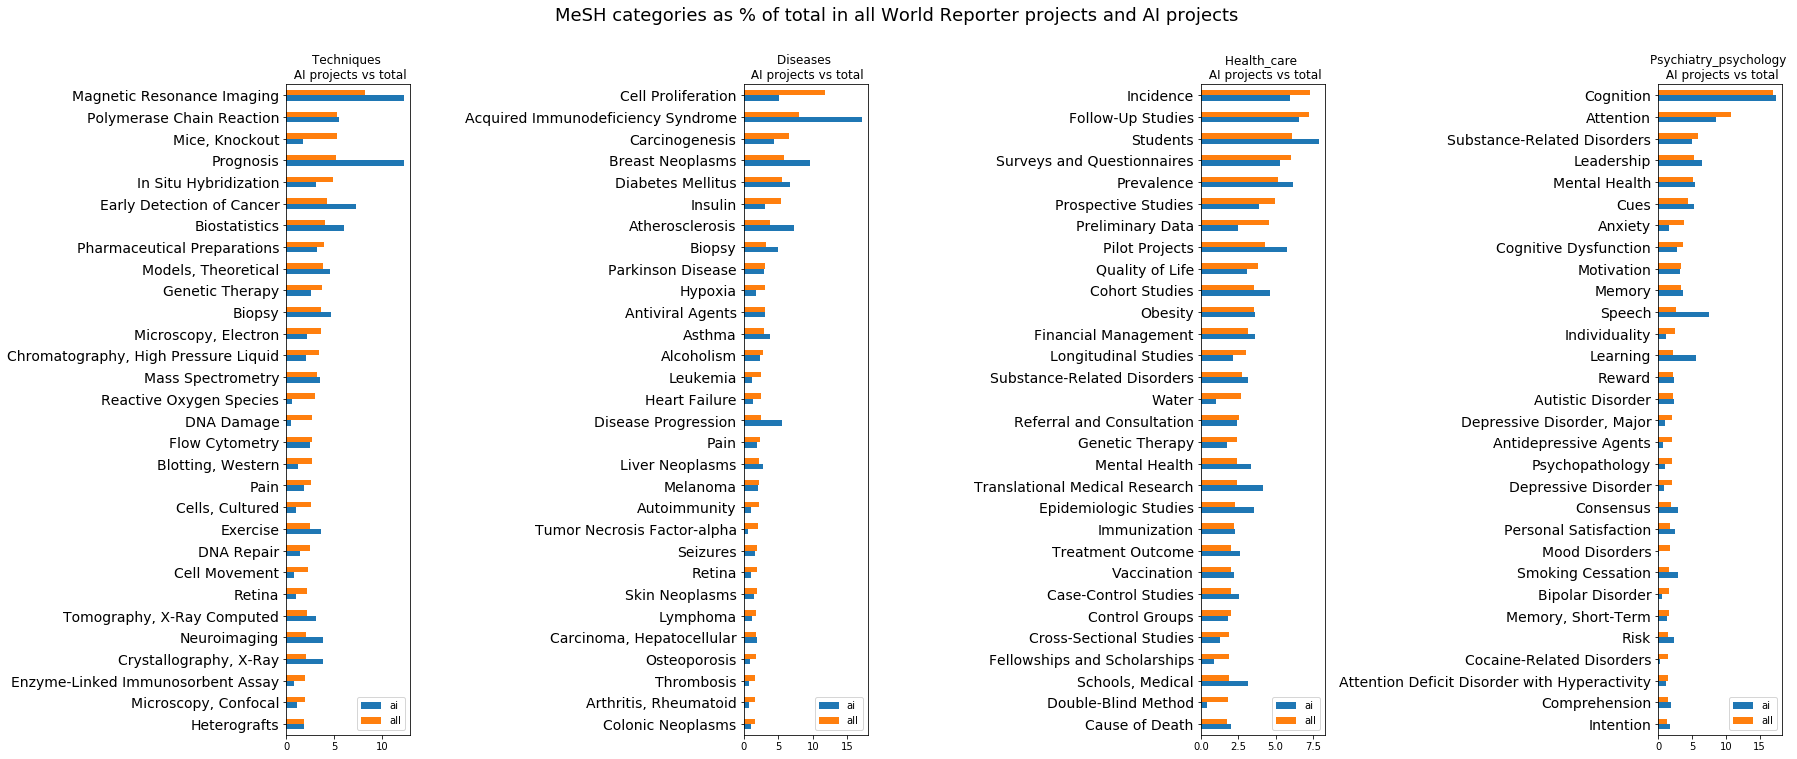

In [214]:
fig,ax = plt.subplots(figsize=(25,10),ncols=4)

for n,x in enumerate(to_plot[:4]):
    
    top_categories = comparisons[x[0]].iloc[:,1].sort_values(ascending=True)[-30:].index
    (100*comparisons[x[0]].loc[top_categories].apply(lambda x: x/x.sum(),axis=0)).plot.barh(ax=ax[n])
    
    ax[n].set_title(f'{x[1]} \n AI projects vs total')
    ax[n].set_yticklabels(ax[n].get_yticklabels(),size=14)
    ax[n].legend(['ai','all'],loc='lower right')
    

plt.tight_layout()

fig.suptitle('MeSH categories as % of total in all World Reporter projects and AI projects',y=1.05,size=18)

plt.savefig(f'../reports/figures/{today_str}_ai_comparison.pdf',bbox_inches='tight')

In [140]:
ai[['title_of_organisation','title_of_project','textBody_abstract_project','date_start_project','terms_mesh_abstract','placeName_country_organisation']]

,title_of_organisation,title_of_project,textBody_abstract_project,date_start_project,terms_mesh_abstract,placeName_country_organisation
0,VIRGINIA COMMONWEALTH UNIVERSITY,Modeling Dimensionality and Genetic Heterogene...,? DESCRIPTION (provided by applicant): Schizop...,2016-03-15,"[United States, Humans, Risk Factors, Genome-W...",UNITED STATES
1,INDIANA UNIV-PURDUE UNIV AT INDIANAPOLIS,Regulation of mRNA splicing by intronic geneti...,? DESCRIPTION (provided by applicant): Genetic...,2016-06-01,"[Humans, clofarabine, Introns, RNA, Small Inte...",UNITED STATES
2,"BIOFORMATIX, INC.",Diagnostic aid software for the visual field test,"Visual field (VF) test is a widely used, nonin...",2002-01-02,"[Humans, Visual Fields, Visual Pathways, Visua...",UNITED STATES
3,NaN,NaN,Most drugs and other xenobiotics are extensive...,NaN,"[Animals, Humans, Rabbits, dimethylaniline mon...",NaN
4,"NEURAL SIGNALS, INC.",A Direct Brain to Speech Generator for use in ...,[unreadable] DESCRIPTION (provided by applica...,2004-09-06,"[Humans, Young Adult, Adult, Motor Cortex, Spe...",UNITED STATES
5,WASHINGTON UNIVERSITY,PROMOTERS,? DESCRIPTION (provided by applicant): The lon...,2011-01-01,"[Chromatin, Transcription Factors, Goals, Regu...",UNITED STATES
6,HARVARD MEDICAL SCHOOL,Aim 4: Target discovery for common disease mec...,PROJECT SUMMARY The studies in Aim 4 represent...,NaN,"[Humans, PTPN11 protein, human, Protein Tyrosi...",UNITED STATES
7,MASSACHUSETTS GENERAL HOSPITAL,"Endotoxin, the airway transcriptome, and obstr...",DESCRIPTION (provided by applicant): Research ...,2013-09-23,"[Female, Child, United States, Humans, Asthma,...",UNITED STATES
8,UNIVERSITY OF CALIFORNIA LOS ANGELES,Utilizing Traditional Practices to Decrease Su...,? DESCRIPTION (provided by applicant): Drum-As...,2016-08-01,"[Humans, Adult, Male, Female, Alaska Natives, ...",UNITED STATES
9,UNIVERSITY OF WASHINGTON,"Outreach, Recruitment & Education Core",CORE E: ORE - ABSTRACT The primary objective o...,NaN,"[Humans, United States, Alzheimer Disease, Ala...",UNITED STATES


### Line chart

Shows AI as share of all WR projects over time

In [151]:
wr['wr_year'] = wr.date_start_project.apply(lambda x: int(x.split('-')[0]) if pd.isnull(x)==False else np.nan)
ai['ai_year'] = ai.date_start_project.apply(lambda x: int(x.split('-')[0]) if pd.isnull(x)==False else np.nan)

In [156]:
year_act = pd.concat([wr['wr_year'].value_counts(),ai['ai_year'].value_counts()],axis=1).fillna(0)

year_act['ai_share']= year_act['ai_year']/year_act['wr_year']

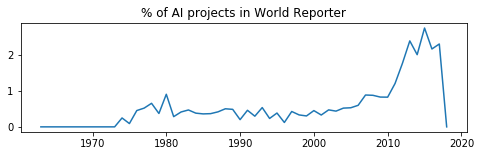

In [163]:
fig,ax = plt.subplots(figsize=(8,2))

(100*year_act['ai_share']).plot(title='% of AI projects in World Reporter',ax=ax)

plt.savefig('../reports/figures/ai_trends.pdf')

Up it goes!

#### TODO

* Evolution in the popularity of different topics
* Cluster MeSH terms into higher level meaningful categories? Their taxonomy doesn't map well against issues plus it would be nice to identify cross-cutting clusters of terms.